# Notebook 3: Ingeniería de Características y Clasificación con Convex Hull

Este notebook une los dos mundos que exploramos anteriormente. Combinaremos las características lingüísticas del análisis POS y las métricas semánticas del análisis de coherencia para crear un espacio de características multidimensional. Luego, entrenaremos nuestro `ConvexHullClassifier` para aprender a distinguir entre diferentes clases de textos (en este caso, los filósofos) basándose en estas características. Finalmente, visualizaremos los resultados para entender cómo el clasificador separa los datos.

In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull

# Añadir el directorio raíz del proyecto al path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src.philosophical_analysis.core.pos_analyzer import AdvancedPOSAnalyzer
from src.philosophical_analysis.core.enhanced_coherence import EnhancedCoherenceAnalyzer
from src.philosophical_analysis.core.convex_hull import ConvexHullClassifier

sns.set_theme(style="whitegrid")
print("Librerías y módulos cargados correctamente.")

Librerías y módulos cargados correctamente.


## 1. Cargar Textos y Generar Características

In [3]:
# Cargar textos
data_path = project_root / "data" / "raw"
texts = {file_path.stem.replace("_style", "").capitalize(): file_path.read_text(encoding='utf-8') for file_path in data_path.glob("*.txt")}
texts_dict = {name.lower(): content for name, content in texts.items()}

# Generar características POS
pos_analyzer = AdvancedPOSAnalyzer()
pos_results = [pos_analyzer.full_pos_analysis(text) for text in texts.values()]
df_pos = pd.DataFrame(pos_results, index=texts.keys())

# Generar características de Coherencia
coherence_analyzer = EnhancedCoherenceAnalyzer(n_components=15)
coherence_analyzer.fit(texts_dict)
coherence_results = [coherence_analyzer.comprehensive_analysis(text) for text in texts.values()]
df_coherence = pd.DataFrame(coherence_results, index=texts.keys())

# Combinar en un solo DataFrame de características
df_features = pd.concat([df_pos, df_coherence], axis=1)

print("DataFrame de características creado con éxito.")
df_features.head()

INFO:src.philosophical_analysis.core.pos_analyzer:Advanced POS Analyzer initialized with paper specifications
INFO:src.philosophical_analysis.core.pos_analyzer:Starting advanced POS analysis for: 
INFO:src.philosophical_analysis.core.pos_analyzer:POS analysis completed for 
INFO:src.philosophical_analysis.core.pos_analyzer:Starting advanced POS analysis for: 
INFO:src.philosophical_analysis.core.pos_analyzer:POS analysis completed for 
INFO:src.philosophical_analysis.core.pos_analyzer:Starting advanced POS analysis for: 
INFO:src.philosophical_analysis.core.pos_analyzer:POS analysis completed for 
INFO:src.philosophical_analysis.core.pos_analyzer:Starting advanced POS analysis for: 
INFO:src.philosophical_analysis.core.pos_analyzer:POS analysis completed for 
INFO:src.philosophical_analysis.core.pos_analyzer:Starting advanced POS analysis for: 
INFO:src.philosophical_analysis.core.pos_analyzer:POS analysis completed for 
INFO:src.philosophical_analysis.core.pos_analyzer:Starting advanc

DataFrame de características creado con éxito.


,text_id,sentence_count,total_words,target_determiners_count,target_determiners_freq,max_phrase_length,avg_sentence_length,syntactic_complexity,analysis_type,text_id,...,coherence_trend,local_coherence_variance,phrase_separated_coherence,distant_coherence,coherence_decay_rate,t_statistic,p_value,effect_size,significant,analysis_type
Plato_republic,,7772,216898,6327,0.029170,20,27.907617,"{'avg_sentence_length': 27.9076170869789, 'max...",advanced_pos,,...,-0.363712,0.025868,0.510222,0.500860,0.011909,78.394933,0.000000e+00,0.888902,True,enhanced_coherence
Aquinas_summa_theologica,,23516,491422,14762,0.030039,20,20.897346,"{'avg_sentence_length': 20.897346487497874, 'm...",advanced_pos,,...,-0.045857,0.029977,0.417952,0.400098,0.018820,76.234640,0.000000e+00,0.495773,True,enhanced_coherence
Descartes_discourse_method,,381,25958,1045,0.040257,23,68.131234,"{'avg_sentence_length': 68.13123359580052, 'ma...",advanced_pos,,...,-0.483524,0.021896,0.691453,0.683310,0.006573,37.594370,3.123437e-132,1.893977,True,enhanced_coherence
Nietzsche_beyond_good_evil,,1647,62922,1687,0.026811,59,38.204007,"{'avg_sentence_length': 38.2040072859745, 'max...",advanced_pos,,...,-0.059312,0.023935,0.532608,0.515483,0.016224,43.272096,7.988931e-274,1.066255,True,enhanced_coherence
Aristotle_nicomachean_ethics,,2756,115098,3164,0.027490,21,41.762700,"{'avg_sentence_length': 41.762699564586356, 'm...",advanced_pos,,...,-0.314979,0.020535,0.573105,0.559121,0.013630,71.611883,0.000000e+00,1.356733,True,enhanced_coherence


## 2. Entrenar el Clasificador Convex Hull

In [4]:
# Seleccionar un subconjunto de características para la clasificación
features_for_classification = [
    'first_order_coherence',
    'target_determiners_freq',
    'max_phrase_length',
    'avg_sentence_length'
]

X = df_features[features_for_classification].values

# Usar los nombres de los filósofos como etiquetas
labels = df_features.index.to_list()

# Entrenar el clasificador
classifier = ConvexHullClassifier(features=features_for_classification)
classifier.fit(X, labels)

print("Clasificador entrenado. Clases aprendidas:", classifier.hulls.keys())

INFO:src.philosophical_analysis.core.convex_hull:Convex Hull Classifier initialized with features: ['first_order_coherence', 'target_determiners_freq', 'max_phrase_length', 'avg_sentence_length']
INFO:src.philosophical_analysis.core.convex_hull:Fitting convex hull classifier on 11 samples
INFO:src.philosophical_analysis.core.convex_hull:Convex hull classifier fitted successfully


Clasificador entrenado. Clases aprendidas: dict_keys([np.str_('Aquinas_summa_theologica'), np.str_('Aristotle_nicomachean_ethics'), np.str_('Descartes_discourse_method'), np.str_('Descartes_meditations'), np.str_('Hume_human_understanding'), np.str_('James_pragmatism'), np.str_('Kant_critique_pure_reason'), np.str_('Maimonides_guide_perplexed'), np.str_('Nietzsche_beyond_good_evil'), np.str_('Plato_apology'), np.str_('Plato_republic')])


## 3. Visualizar el Espacio de Características y los Cascos Convexos

Como nuestro espacio de características tiene 4 dimensiones, usaremos PCA (Análisis de Componentes Principales) para reducirlo a 2 dimensiones y poder visualizarlo. Esto nos permite ver una "sombra" 2D de los cascos convexos 4D.

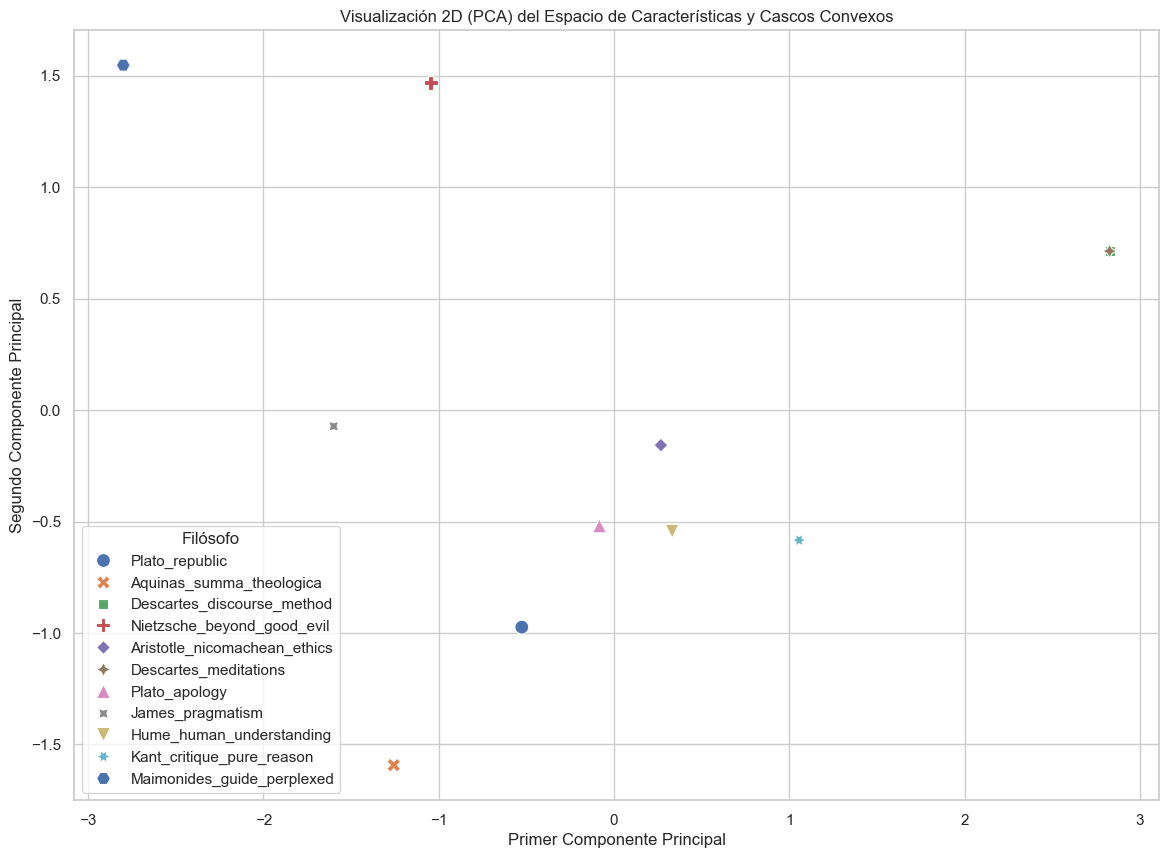

In [5]:
# Reducir dimensionalidad con PCA
pca = PCA(n_components=2)
X_scaled = classifier.scaler.transform(X) # Usar el scaler del clasificador
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(14, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, s=100, style=labels, palette='deep')

# Dibujar los cascos convexos para cada clase en el espacio PCA
for label in np.unique(labels):
    # Encontrar los puntos correspondientes a esta clase
    points_for_label = X_pca[np.array(labels) == label]
    
    # El casco convexo solo se puede dibujar si hay al menos 3 puntos
    if len(points_for_label) >= 3:
        hull = ConvexHull(points_for_label)
        # Dibujar el casco
        for simplex in hull.simplices:
            plt.plot(points_for_label[simplex, 0], points_for_label[simplex, 1], 'k-', alpha=0.5)

plt.title('Visualización 2D (PCA) del Espacio de Características y Cascos Convexos')
plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.legend(title='Filósofo')
plt.show()